<a href="https://colab.research.google.com/github/Shubodh/pytorch_geometric/blob/dimenet_shub/examples/Deep_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
from itertools import combinations
from math import sqrt

atomic_radii = dict(Ac=1.88, Ag=1.59, Al=1.35, Am=1.51, As=1.21, Au=1.50, B=0.83, Ba=1.34, Be=0.35, Bi=1.54, Br=1.21,
                    C=0.68, Ca=0.99, Cd=1.69, Ce=1.83, Cl=0.99, Co=1.33, Cr=1.35, Cs=1.67, Cu=1.52, D=0.23, Dy=1.75,
                    Er=1.73, Eu=1.99, F=0.64, Fe=1.34, Ga=1.22, Gd=1.79, Ge=1.17, H=0.23, Hf=1.57, Hg=1.70, Ho=1.74,
                    I=1.40, In=1.63, Ir=1.32, K=1.33, La=1.87, Li=0.68, Lu=1.72, Mg=1.10, Mn=1.35, Mo=1.47, N=0.68,
                    Na=0.97, Nb=1.48, Nd=1.81, Ni=1.50, Np=1.55, O=0.68, Os=1.37, P=1.05, Pa=1.61, Pb=1.54, Pd=1.50,
                    Pm=1.80, Po=1.68, Pr=1.82, Pt=1.50, Pu=1.53, Ra=1.90, Rb=1.47, Re=1.35, Rh=1.45, Ru=1.40, S=1.02,
                    Sb=1.46, Sc=1.44, Se=1.22, Si=1.20, Sm=1.80, Sn=1.46, Sr=1.12, Ta=1.43, Tb=1.76, Tc=1.35, Te=1.47,
                    Th=1.79, Ti=1.47, Tl=1.55, Tm=1.72, U=1.58, V=1.33, W=1.37, Y=1.78, Yb=1.94, Zn=1.45, Zr=1.56)


class MolGraph_mod:
    """Represents a molecular graph."""
    __slots__ = ['elements', 'x', 'y', 'z', 'adj_list',
                 'atomic_radii', 'bond_lengths']

    def __init__(self):
        self.elements = []
        self.x = []
        self.y = []
        self.z = []
        self.adj_list = {}
        self.atomic_radii = []
        self.bond_lengths = {}

    def read_xyz(self,molxyz):
        """Reads an XYZ file, searches for elements and their cartesian coordinates
        and adds them to corresponding arrays."""
        pattern = re.compile(r'([A-Za-z]{1,3})\s*(-?\d+(?:\.\d+)?)\s*(-?\d+(?:\.\d+)?)\s*(-?\d+(?:\.\d+)?)')
        for element, x, y, z in pattern.findall(str(molxyz)):
            self.elements.append(element)
            self.x.append(float(x))
            self.y.append(float(y))
            self.z.append(float(z))
        self.atomic_radii = [atomic_radii[element] for element in self.elements]
        self._generate_adjacency_list()

    def _generate_adjacency_list(self):
        """Generates an adjacency list from atomic cartesian coordinates."""
        node_ids = range(len(self.elements))
        for i, j in combinations(node_ids, 2):
            x_i, y_i, z_i = self.__getitem__(i)[1]
            x_j, y_j, z_j = self.__getitem__(j)[1]
            distance = sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2 + (z_i - z_j) ** 2)
            if 0.1 < distance < (self.atomic_radii[i] + self.atomic_radii[j]) * 1.3:
                dist_limit = (self.atomic_radii[i] + self.atomic_radii[j]) * 1.3
                self.adj_list.setdefault(i, set()).add(j)
                self.adj_list.setdefault(j, set()).add(i)
                self.bond_lengths[frozenset([i, j])] = round(((distance-0.1)/(dist_limit-0.1)), 5)

    def edges(self):
        """Creates an iterator with all graph edges."""
        edges = set()
        for node, neighbours in self.adj_list.items():
            for neighbour in neighbours:
                edge = frozenset([node, neighbour])
                if edge in edges:
                    continue
                edges.add(edge)
                yield node, neighbour
                


    def __len__(self):
        return len(self.elements)

    def __getitem__(self, position):
        return self.elements[position], (
            self.x[position], self.y[position], self.z[position])
    

In [ ]:
from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import init_notebook_mode, iplot
import networkx as nx
import numpy as np

# Initiate the Plotly notebook mode
init_notebook_mode(connected=True)

def to_networkx_graph(graph: MolGraph_mod) -> nx.Graph:
    """Creates a NetworkX graph.
    Atomic elements and coordinates are added to the graph as node attributes 'element' and 'xyz" respectively.
    Bond lengths are added to the graph as edge attribute 'length''"""
    G = nx.Graph(graph.adj_list)
    node_attrs = {num: {'element': element, 'xyz': xyz} for num, (element, xyz) in enumerate(graph)}
    nx.set_node_attributes(G, node_attrs)
    edge_attrs = {edge: {'length': length} for edge, length in graph.bond_lengths.items()}
    nx.set_edge_attributes(G, edge_attrs)
    return G


data = open('tmQM_X1.xyz',"r").read().splitlines()

#this block of code extracts structures containing Fe and convert them into networkx readable graph. 
#"graphs" contains all the individual molecular graphs containing Fe. Total 4446 complexes are  found. 
#nodes contains information about the type of atoms/nodes present in each molecular graphs 
graphs = []
nodes = []
for ndx, line in enumerate(data):
    #print(line)
    if ndx < len(data)-1:
        if line == '':
            total_atoms_in_mol = int(data[ndx+1])
            #print(total_atoms_in_mol,ndx+1+total_atoms_in_mol)
            mol_xyz = data[ndx+1:ndx+1+total_atoms_in_mol]
            #finds complexes containing Fe (Iron)
            if 'Fe' in np.array(mol_xyz)[1]:
                mol = MolGraph_mod()
                # Read the data from the xyz coordinate block
                mol.read_xyz(mol_xyz)
                elements = set(mol.elements)
                nodes.append(elements)
                G = to_networkx_graph(mol)
                graphs.append(G)


In [ ]:
print(len(graphs))
print(nodes)

4446
[{'S', 'C', 'Fe', 'N', 'H'}, {'S', 'C', 'H', 'O', 'N', 'Fe'}, {'P', 'C', 'Fe', 'O', 'H'}, {'Fe', 'Cl', 'C', 'H'}, {'C', 'Fe', 'Cl', 'N', 'H'}, {'P', 'C', 'H', 'B', 'Fe', 'Br'}, {'C', 'H', 'Fe', 'N'}, {'C', 'H', 'Fe', 'N'}, {'C', 'H', 'Fe', 'N'}, {'C', 'H', 'O', 'B', 'N', 'Si', 'Fe'}, {'C', 'H', 'O', 'N', 'Si', 'Fe'}, {'C', 'H', 'O', 'N', 'I', 'Fe'}, {'C', 'H', 'Cl', 'N', 'Fe'}, {'P', 'C', 'Fe', 'Se', 'H'}, {'Fe', 'C', 'H', 'N'}, {'C', 'O', 'H', 'Fe'}, {'C', 'Fe', 'O', 'N', 'H'}, {'C', 'Fe', 'O', 'Si', 'H'}, {'P', 'C', 'H', 'O', 'N', 'Fe'}, {'C', 'H', 'Fe', 'P'}, {'C', 'Fe', 'N', 'H', 'Br'}, {'P', 'C', 'H', 'O', 'N', 'Fe'}, {'P', 'C', 'Fe', 'Si', 'H', 'Br'}, {'C', 'Fe', 'O', 'N', 'H'}, {'C', 'H', 'Cl', 'N', 'Fe'}, {'C', 'Fe', 'N', 'H', 'Br'}, {'P', 'C', 'Fe', 'O', 'H'}, {'S', 'C', 'Fe', 'O', 'N', 'H'}, {'C', 'Fe', 'Cl', 'N', 'H'}, {'C', 'H', 'Cl', 'N', 'Fe'}, {'C', 'Fe', 'O', 'Si', 'H'}, {'C', 'O', 'H', 'Fe'}, {'C', 'H', 'Fe', 'N'}, {'C', 'Fe', 'O', 'N', 'H'}, {'C', 'Fe', 'O', 'N',

In [ ]:
import numpy as np
import torch
from torch_geometric.utils.convert import from_networkx

# Convert the graph into PyTorch geometric

bfs = nx.bfs_tree(graphs[0], source=0)
#print(list(bfs))


pyg_graph = from_networkx(bfs)
print(pyg_graph)

print('node feature matrix:',pyg_graph.x)

#Target to train against (may have arbitrary shape), e.g., node-level targets of shape 
print('output:',pyg_graph.y)

#Graph connectivity in COO format with shape [2, num_edges] and type torch.long
print('edge_index:',pyg_graph.edge_index)

#Edge feature matrix with shape [num_edges, num_edge_features]
print(pyg_graph.edge_attr)

#Node position matrix with shape [num_nodes, num_dimensions]
print(pyg_graph.pos)


Data(edge_index=[2, 52], num_nodes=53)
node feature matrix: None
output: None
edge_index: tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  5,  6,  6,  7,  7,  8,
          8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 14, 14, 15, 15, 16, 19, 20, 23,
         25, 27, 30, 31, 33, 33, 33, 35, 35, 35, 38, 38, 38, 40, 40, 40],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]])
None
None


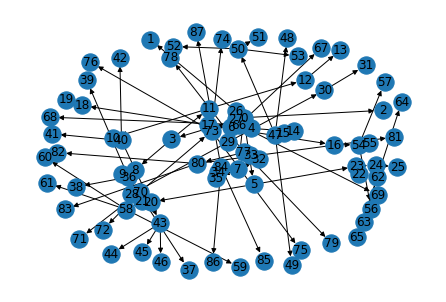

In [ ]:
G = to_networkx_graph(mg1)
bfs = nx.bfs_tree(G, source=0)
nx.draw(bfs, with_labels = True)

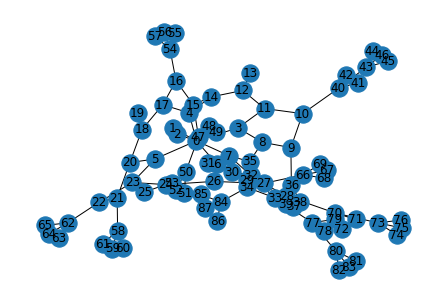

In [ ]:
nx.draw(G,with_labels=True)